In [1]:
import numpy as np
import scipy
from matplotlib import pyplot as plt
import time
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ExpSineSquared, RationalQuadratic
from sklearn.gaussian_process import GaussianProcessRegressor

In [2]:
def construct_RQ_kernel(params, bound = False):
    if bound:
        kernel = params[0] * RationalQuadratic(length_scale=params[1], 
                                               alpha=params[2], alpha_bounds = (1/5 * params[2], 5 * params[2]))
    else:
        kernel = params[0] * RationalQuadratic(length_scale=params[1], alpha=params[2])
    return kernel

def simulate(n, true_params, initial_params, eps, num_restarts = 1):
    x = np.linspace(start = 0, stop = 1, num = n).reshape(-1, 1)
    shift = np.random.uniform(-1 / (4 * n), 1 / (4 * n), size=n).reshape(-1, 1)
    x = x + shift
    true_kernel = construct_RQ_kernel(true_params) + WhiteKernel(noise_level=eps)
    true_gp = GaussianProcessRegressor(kernel=true_kernel, alpha=0)
    y = np.squeeze(true_gp.sample_y(x, random_state=None))
    #plt.plot(x, y)
    
    kernel = construct_RQ_kernel(initial_params, bound = True)
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=num_restarts, alpha=eps)
    gp.fit(x, y)
    
    gp_params = gp.kernel_.get_params()
    numerical_params = [value for key, value in gp_params.items() if isinstance(value, (int, float, np.float64))]
    return numerical_params

n = 500
true_params = [1, 1/300, 3]
initial_params = [1 * p for p in true_params]
eps = 0.1
simulate(n, true_params, initial_params, eps, 0)
    

[0.9670693927057576, 0.003246056907439541, 2.530569065791288]

In [3]:
def get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates):
    # Collect estimates
    estimates = []
    for n in sample_sizes:
        estimates.append([simulate(n, true_params, initial_params, eps, num_restarts) for _ in range(num_replicates)])
    
    param_estimates = [[[est[i] for est in sample] for sample in estimates] for i in range(len(true_params))]
    flattened_estimates = np.array(param_estimates).reshape(len(true_params), -1)  # Flatten the nested list
    np.savetxt('./results/rational-quadratic-simulation.txt', flattened_estimates)
    return param_estimates
    
def generate_boxplots(param_estimates, true_params, sample_sizes, param_names):
    # Create boxplots
    fig, axs = plt.subplots(1, len(true_params), figsize=(18, 6))
    for i, param_estimate in enumerate(param_estimates):
        axs[i].boxplot(param_estimate, labels=sample_sizes, vert=True)
        axs[i].axhline(y=true_params[i], color='r', alpha=0.5, linestyle='--')
        axs[i].set_xticks(range(1, len(sample_sizes) + 1))
        axs[i].set_xlabel('Sample Size', fontsize=15)
        axs[i].set_title(f'{param_names[i]}', fontsize=20)

    plt.tight_layout()
    plt.savefig('./boxplots/rational-quadratic-simulation.png')
    plt.show()

# Timing execution
start_time = time.time()

# Parameters
num_replicates = 100
true_params = [1, 1/300, 3]
initial_params = [1 * p for p in true_params]
eps = 0.1
num_restarts = 0
sample_sizes = [50, 100, 200, 500]  # Example sample sizes

# Generate plots
np.random.seed(2024)
param_estimates = get_param_estimates(sample_sizes, true_params, initial_params, eps, num_restarts, num_replicates)

end_time = time.time()
execution_time = end_time - start_time
print("Execution time:", execution_time, "seconds")


/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:411: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified upper bound 15.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn("The optimal value found for "
/nas/longleaf/rhel8/apps/anaconda/2021.11.ood/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:402: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 0.6000000000000001. Decreasing the bound and calli

Execution time: 216.550372838974 seconds


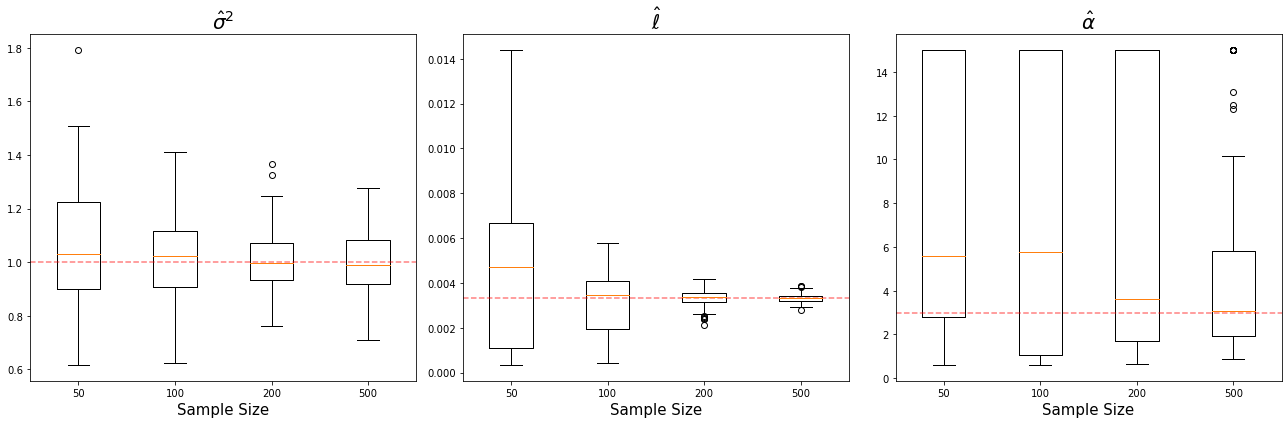

In [4]:
flattened_estimates = np.loadtxt('./results/rational-quadratic-simulation.txt')
param_estimates = flattened_estimates.reshape(len(true_params), len(sample_sizes), num_replicates).tolist()
param_names = [r'$\hat{\sigma}^2$', r'$\hat{\ell}$', r'$\hat{\alpha}$']
generate_boxplots(param_estimates, true_params, sample_sizes, param_names)

In [5]:
def check(n, params):
        kernel = construct_RQ_kernel(params)
        print(kernel)
        x = np.linspace(0, 1, n)
        K = kernel([[p] for p in x])
        eigvals = np.sort(np.linalg.eigvals(K))
        print(np.linalg.cond(K))
        print(eigvals)
    
n = 500
params =  [1, 1/500, 3]
check(n, params)

1**2 * RationalQuadratic(alpha=3, length_scale=0.002)
38.18370604647268
[0.07542406 0.07543983 0.07546612 0.07550293 0.07555027 0.07560813
 0.07567653 0.07575547 0.07584496 0.07594502 0.07605565 0.07617686
 0.07630867 0.0764511  0.07660415 0.07676785 0.07694221 0.07712725
 0.077323   0.07752947 0.07774668 0.07797467 0.07821345 0.07846306
 0.07872351 0.07899484 0.07927708 0.07957026 0.07987441 0.08018956
 0.08051575 0.08085301 0.08120138 0.08156091 0.08193161 0.08231355
 0.08270676 0.08311127 0.08352715 0.08395442 0.08439315 0.08484336
 0.08530512 0.08577848 0.08626348 0.08676017 0.08726862 0.08778887
 0.08832098 0.08886501 0.08942102 0.08998907 0.09056921 0.09116151
 0.09176604 0.09238285 0.09301202 0.0936536  0.09430768 0.09497431
 0.09565357 0.09634554 0.09705027 0.09776786 0.09849837 0.09924188
 0.09999847 0.10076822 0.10155121 0.10234753 0.10315725 0.10398046
 0.10481725 0.1056677  0.1065319  0.10740994 0.10830192 0.10920792
 0.11012805 0.11106238 0.11201103 0.11297409 0.11395165 0